In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
n_s = 1000
n_d = 100
n_train = 10
n_params = 1
n_summaries = 2
input_shape = (10,)
t_fid = np.array([1.])
dt = np.array([0.1])
ns = tf.constant(n_s, dtype=tf.float32)
nd = tf.constant(n_d, dtype=tf.float32)
θ_fid = tf.constant(t_fid, dtype=tf.float32)
dθ = tf.constant(dt, dtype=tf.float32)

In [3]:
seed = 0
np.random.seed(seed)
training_simulations = np.random.normal(0., np.sqrt(t_fid[0]), (n_train * max(n_s, n_d),) + input_shape)[:n_train * n_s].astype(np.float32)
np.random.seed(seed)
training_simulations_m = np.random.normal(0., np.sqrt(t_fid[0] - dt[0]), (n_train * max(n_s, n_d), n_params) + input_shape)[:n_train * n_d].astype(np.float32)
np.random.seed(seed)
training_simulations_p = np.random.normal(0., np.sqrt(t_fid[0] + dt[0]), (n_train * max(n_s, n_d), n_params) + input_shape)[:n_train * n_d].astype(np.float32)
seed = 1
np.random.seed(seed)
test_simulations = np.random.normal(0., np.sqrt(t_fid[0]), (max(n_s, n_d),) + input_shape)[:n_s].astype(np.float32)
np.random.seed(seed)
test_simulations_m = np.random.normal(0., np.sqrt(t_fid[0] - dt[0]), (max(n_s, n_d), n_params) + input_shape)[:n_d].astype(np.float32)
np.random.seed(seed)
test_simulations_p = np.random.normal(0., np.sqrt(t_fid[0] + dt[0]), (max(n_s, n_d), n_params) + input_shape)[:n_d].astype(np.float32)

In [4]:
sims_at_once = 17

training_set = tf.data.Dataset.from_tensor_slices(training_simulations)
training_set = training_set.batch(n_s).shuffle(n_s * n_train).repeat()
training_set = training_set.map(lambda x: tf.data.Dataset.from_tensor_slices(x).batch(sims_at_once).repeat(2))
indices = tf.data.Dataset.from_tensor_slices(np.arange(n_s)[:, np.newaxis].astype(np.int32))
indices = indices.batch(sims_at_once).repeat()

training_derivative_set = tf.data.Dataset.from_tensor_slices((training_simulations_m, training_simulations_p))
training_derivative_set = training_derivative_set.batch(n_d).shuffle(n_d * n_train).repeat()
training_derivative_set = training_derivative_set.map(lambda x, y: (tf.data.Dataset.from_tensor_slices((x, y)).batch(sims_at_once).repeat(2)))
derivative_indices = tf.data.Dataset.from_tensor_slices(np.arange(n_d)[:, np.newaxis].astype(np.int32))
derivative_indices = derivative_indices.batch(sims_at_once).repeat()

In [5]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=(10,)),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(128),
     tf.keras.layers.Activation("tanh"),
     tf.keras.layers.Dense(n_summaries),
     tf.keras.layers.Activation("tanh")
    ])
opt = tf.keras.optimizers.Adam()

In [6]:
batches = np.ceil(n_s / sims_at_once).astype(int)
derivative_batches = np.ceil(n_d / sims_at_once).astype(int)
data_iterator = iter(training_set)
data_derivative_iterator = iter(training_derivative_set)
indices_iterator = iter(indices)
derivative_indices_iterator = iter(derivative_indices)

In [7]:
simulator_iterator = iter(next(data_iterator))
derivative_iterator = iter(next(data_derivative_iterator))
for j in range(batches):
    simulations = next(simulator_iterator)
    inds = next(indices_iterator)
    with tf.GradientTape() as tape:
        x = model(simulations)
    dxdw = tape.jacobian(x, model.variables)

In [37]:
@tf.function
def staggered_train(data_iterator, data_derivative_iterator, indices_iterator, 
                    derivative_indices_iterator, λ, α):
    simulator_iterator = iter(next(data_iterator))
    derivative_iterator = iter(next(data_derivative_iterator))
    x = tf.zeros(shape=(n_s, n_summaries))
    for j in range(batches):
        simulations = next(simulator_iterator)
        inds = next(indices_iterator)
        x = tf.tensor_scatter_nd_update(x, inds, model(simulations))
    x_m = tf.zeros(shape=(n_d, n_params, n_summaries))
    x_p = tf.zeros(shape=(n_d, n_params, n_summaries))
    for j in range(derivative_batches):
        simulations_m, simulations_p = next(derivative_iterator)
        inds = next(derivative_indices_iterator)
        x_m = tf.tensor_scatter_nd_update(x_m, inds, model(simulations_m))
        x_p = tf.tensor_scatter_nd_update(x_p, inds, model(simulations_p))
    
    C, μ_offset = get_covariance(x)
    Cinv = tf.linalg.inv(C)
    dμdθ = get_derivative_mean(x_m, x_p)
    F = get_Fisher(Cinv, dμdθ)
    
    dCdx = get_covariance_derivative(μ_offset)
    dΛdx, dΛdx_m, dΛdx_p = get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx)
    dΛ_2dx, r = get_regularisation_derivative(C, Cinv, dCdx, λ, α)
    dΛdx = tf.add(dΛ_2dx, dΛdx)
    
    gradients = [tf.zeros(model.variables[layer].shape) for layer in range(len(model.variables))]
    for j in range(batches):
        simulations = next(simulator_iterator)
        inds = next(indices_iterator)
        with tf.GradientTape() as tape:
            x = model(simulations)
        dxdw = tape.jacobian(x, model.variables)
        for layer in range(len(model.variables)):
            gradients[layer] = tf.add(
                gradients[layer],
                tf.divide(
                    tf.einsum(
                        "ij,ij...->...", 
                        tf.gather_nd(dΛdx, inds),
                        dxdw[layer]),
                    tf.dtypes.cast(
                        tf.shape(inds)[0],
                        tf.float32)))
    for j in range(derivative_batches):
        simulations_m, simulations_p = next(derivative_iterator)
        inds = next(derivative_indices_iterator)
        with tf.GradientTape(persistent=True) as tape:
            x_m = model(simulations_m)
            x_p = model(simulations_p)
        dx_mdw = tape.jacobian(x_m, model.variables)
        dx_pdw = tape.jacobian(x_p, model.variables)
        del tape
        for layer in range(len(model.variables)):
            gradients[layer] = tf.add(
                gradients[layer],
                tf.divide(
                    tf.add(
                        tf.einsum(
                            "ijk,ijk...->...", 
                            tf.gather_nd(dΛdx_m, inds),
                            dx_mdw[layer]),
                        tf.einsum(
                            "ijk,ijk...->...", 
                            tf.gather_nd(dΛdx_p, inds), 
                            dx_pdw[layer])),
                    tf.dtypes.cast(
                        tf.shape(inds)[0],
                        tf.float32)))
    opt.apply_gradients(zip(gradients, model.variables))
    return tf.linalg.det(F), tf.linalg.det(C), tf.linalg.det(Cinv), dμdθ, r

In [9]:
def get_covariance(x):
    μ = tf.reduce_mean(x, 
                       axis=0, 
                       keepdims=True)
    μ_offset = tf.subtract(x, μ)
    
    C = tf.divide(
        tf.einsum(
            "ij,ik->jk", 
            μ_offset, 
            μ_offset), 
        tf.subtract(ns, 1.))
    return C, μ_offset

In [10]:
def get_derivative_mean(x_m, x_p):
    return tf.reduce_mean(
        tf.einsum(
            "ijk,j->ijk",
            tf.subtract(x_p, x_m),
            tf.divide(
                1.,
                tf.multiply(2., dθ))),
            axis=0)

In [11]:
def get_Fisher(Cinv, dμdθ):
    F = tf.linalg.band_part(
            tf.einsum(
                "ij,kj->ik", 
                dμdθ, 
                tf.einsum(
                    "ij,kj->ki", 
                    Cinv, 
                    dμdθ)), 0, -1)
    return tf.multiply(
        0.5, 
        tf.add(
            F, 
            tf.transpose(F, perm=[1, 0])))

In [12]:
def get_covariance_derivative(μ_offset):
    dxdx = tf.einsum(
        "ij,kl->ijkl", 
        tf.eye(n_s, n_s), 
        tf.eye(n_summaries, n_summaries))
    dμ_offsetdx = tf.subtract(
        dxdx, 
        tf.reduce_mean(
            dxdx, 
            axis=0, 
            keepdims=True))
    return tf.divide(
        tf.reduce_sum(
            tf.add(
                tf.einsum(
                    "ijkl,im->ijkml", 
                    dμ_offsetdx, 
                    μ_offset),
                tf.einsum(
                    "ij,iklm->ikjlm",
                    μ_offset, 
                    dμ_offsetdx)),
            axis=0),
        tf.subtract(ns, 1.))

In [13]:
def get_derivative_mean_derivative():
    dxdx = tf.einsum(
        "ij,kl,mn->ijklmn", 
        tf.eye(n_d, n_d),
        tf.eye(n_params, n_params),
        tf.eye(n_summaries, n_summaries))
    ddμdθdx = tf.reduce_mean(
        tf.einsum(
            "ijklmn,l->ijkmnl",
            dxdx, 
            tf.divide(
                1., 
                tf.multiply(2., dθ))), 
        axis=0)
    return ddμdθdx

In [14]:
def get_fisher_derivative(Cinv, dμdθ, dCdx):
    ddμdθdx = get_derivative_mean_derivative()
    Cinvdμdθ = tf.einsum(
        "ij,kj->ki", 
        Cinv, 
        dμdθ)
    dFdx = tf.linalg.band_part(
        tf.einsum(
            "ij,kljm->kmil",
            dμdθ, 
            tf.einsum(
                "ij,kljm->klim",
                Cinv, 
                tf.einsum(
                    "ijkl,mk->imjl",
                    dCdx, 
                    Cinvdμdθ))), 0, -1)
    dFdx = tf.multiply(
        -0.5,
        tf.add(
            dFdx, 
            tf.transpose(
                dFdx, 
                perm=[0, 1, 3, 2])))
    
    dFdx_m_a = tf.linalg.band_part(
            tf.einsum(
                "ijklm,nk->imljn",
                -ddμdθdx, 
                Cinvdμdθ), 0, -1)
    dFdx_m_b = tf.linalg.band_part(
            tf.einsum(
                "ij,kljmn->knmil",
                dμdθ, 
                tf.einsum(
                    "ij,kljmn->klimn",
                    Cinv, 
                    -ddμdθdx)), 0, -1)  
    dFdx_m = tf.multiply(
        0.5,
        tf.add(
            tf.add(
                dFdx_m_a,
                tf.transpose(
                    dFdx_m_a,
                    perm=[0, 1, 2, 4, 3])),
            tf.add(
                dFdx_m_b,
                tf.transpose(
                    dFdx_m_b,
                    perm=[0, 1, 2, 4, 3]))))
    
    dFdx_p_a = tf.linalg.band_part(
            tf.einsum(
                "ijklm,nk->imljn",
                ddμdθdx, 
                Cinvdμdθ), 0, -1)
    dFdx_p_b = tf.linalg.band_part(
            tf.einsum(
                "ij,kljmn->knmil",
                dμdθ, 
                tf.einsum(
                    "ij,kljmn->klimn",
                    Cinv, 
                    ddμdθdx)), 0, -1)  
    dFdx_p = tf.multiply(
        0.5,
        tf.add(
            tf.add(
                dFdx_p_a,
                tf.transpose(
                    dFdx_p_a,
                    perm=[0, 1, 2, 4, 3])),
            tf.add(
                dFdx_p_b,
                tf.transpose(
                    dFdx_p_b,
                    perm=[0, 1, 2, 4, 3]))))
    return dFdx, dFdx_m, dFdx_p

In [15]:
def get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx):
    Finv = tf.linalg.inv(F)
    dFdx, dFdx_m, dFdx_p = get_fisher_derivative(Cinv, dμdθ, dCdx)
    
    dΛdx = -tf.linalg.trace(
        tf.einsum(
            "ij,kljm->klim",
            Finv, 
            dFdx))
    dΛdx_m = -tf.linalg.trace(
        tf.einsum(
            "ij,klmjn->klmin",
            Finv, 
            dFdx_m))
    dΛdx_p = -tf.linalg.trace(
        tf.einsum(
            "ij,klmjn->klmin", 
            Finv, 
            dFdx_p))
    return dΛdx, dΛdx_m, dΛdx_p

In [16]:
def get_regularisation(C, Cinv):
    I = tf.eye(n_summaries)
    CmI = tf.subtract(C, I)
    CinvmI = tf.subtract(Cinv, I)
    Λ_2 = tf.multiply(0.5,
        tf.add(
            tf.square(
                tf.norm(CmI, 
                        ord="fro", 
                        axis=(0, 1))),
            tf.square(
                tf.norm(CinvmI, 
                        ord="fro", 
                        axis=(0, 1)))))
    return Λ_2, CmI

In [17]:
def get_regularisation_strength(Λ_2, λ, α):
    rate = tf.multiply(-α, Λ_2)
    e_rate = tf.exp(rate)
    r = tf.divide(
            tf.multiply(
                λ, 
                Λ_2), 
            tf.add(
                Λ_2, 
                e_rate))
    drdΛ_2 = tf.multiply(
        r, 
        tf.add(
            1., 
            tf.divide(
                tf.multiply(
                    tf.add(
                        1.,
                        tf.multiply(
                            α,
                            Λ_2)),
                    e_rate),
                tf.add(
                    Λ_2,
                    e_rate))))
    return r, drdΛ_2

In [18]:
def get_regularisation_derivative(C, Cinv, dCdx, λ, α):
    Λ_2, CmI = get_regularisation(C, Cinv)
    r, drdΛ_2= get_regularisation_strength(Λ_2, λ, α)
    Cinv2 = tf.einsum(
        "ij,jk->ik", 
        Cinv, 
        Cinv)
    Cinv3 = tf.einsum(
        "ij,jk->ik",
        Cinv2,
        Cinv)
    dΛ_2dx = tf.multiply(
        tf.add(
            tf.multiply(
                Λ_2,
                drdΛ_2),
            r),            
        tf.linalg.trace(
            tf.einsum(
                "ij,kjlm->kilm",
                tf.add(
                    CmI, 
                    tf.subtract(
                        Cinv2, 
                        Cinv3)),
                dCdx)))
    return dΛ_2dx, r

In [19]:
def get_gradients(s):
    with tf.GradientTape(persistent=True) as t:
        x = model(s)
    return x, t.jacobian(x, model.variables, experimental_use_pfor=True)

In [20]:
def apply_gradients(F, C, Cinv, dμdθ, μ_offset, dxdw, dx_mdw, dx_pdw, λ, α):
    dCdx = get_covariance_derivative(μ_offset)    
    dΛdx, dΛdx_m, dΛdx_p = get_log_det_fisher_derivative(F, Cinv, dμdθ, dCdx)
    
    dΛ_2dx, r = get_regularisation_derivative(C, Cinv, dCdx, λ, α)
    dΛdx = tf.add(dΛ_2dx, dΛdx)
    
    gradients = []
    for layer in range(len(model.variables)):
        gradients.append(
            tf.add(
                tf.divide(
                    tf.einsum(
                        "ij,ij...->...", 
                        dΛdx, 
                        dxdw[layer]),
                    ns),
                tf.divide(
                    tf.add(
                        tf.einsum(
                            "ijk,ijk...->...", 
                            dΛdx_m,
                            dx_mdw[layer]),
                        tf.einsum(
                            "ijk,ijk...->...", 
                            dΛdx_p, 
                            dx_pdw[layer])),
                    nd)))
    opt.apply_gradients(zip(gradients, model.variables))
    return r

In [21]:
@tf.function
def training_iteration(s, s_m, s_p, α, λ):
    x, dxdw = get_gradients(s)
    x_m, dx_mdw = get_gradients(s_m)
    x_p, dx_pdw = get_gradients(s_p)
    
    C, μ_offset = get_covariance(x)
    Cinv = tf.linalg.inv(C)
    dμdθ = get_derivative_mean(x_m, x_p)
    
    F = get_fisher(Cinv, dμdθ)
        
    r = apply_gradients(F, C, Cinv, dμdθ, μ_offset, dxdw, dx_mdw, dx_pdw, λ, α)
    
    return tf.linalg.det(F), tf.linalg.det(C), tf.linalg.det(Cinv), dμdθ, r

In [23]:
def get_constraint_rate(ϵ, λ):
    return np.float32(-np.log((λ - 1.) * ϵ + ϵ**2. / (1. + ϵ)) / ϵ)

In [24]:
λ = np.float32(10.)
α = get_constraint_rate(1e-2, λ)

In [36]:
F_arr = []
C_arr = []
Cinv_arr = []
dμdθ_arr = []
r_arr = []

test_F_arr = []
test_C_arr = []
test_Cinv_arr = []
test_dμdθ_arr = []

In [45]:
bar = tqdm.tnrange(1000, desc="iterations")
for iteration in bar:
    for data in range(n_train):
        F_temp, C_temp, Cinv_temp, dμdθ_temp, r_temp = staggered_train(data_iterator, data_derivative_iterator, indices_iterator, derivative_indices_iterator, λ, α)
        F_arr.append(F_temp.numpy())
        C_arr.append(C_temp.numpy())
        Cinv_arr.append(Cinv_temp.numpy())
        dμdθ_arr.append(dμdθ_temp.numpy())
        r_arr.append(r_temp.numpy())
    bar.set_postfix(
        F=F_arr[-1],
        C=C_arr[-1],
        Cinv=Cinv_arr[-1],
        dμdθ=dμdθ_arr[-1],
        r=r_arr[-1])

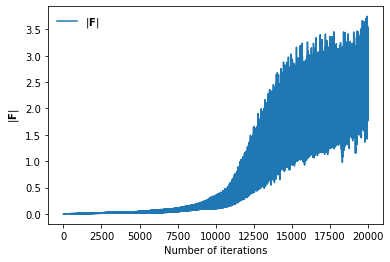

In [62]:
plt.plot(F_arr, color="C0", label="$|{\\bf F}|$")
#plt.plot(test_F_arr, color="C1", label="$|{\\bf F}|_{\\rm test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$|{\\bf F}|$")
plt.legend(frameon=False);

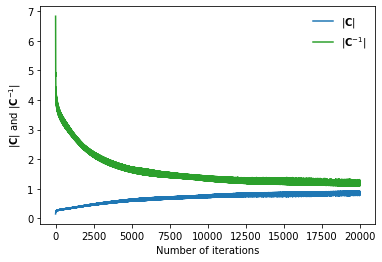

In [61]:
plt.plot(C_arr, color="C0", label="$|{\\bf C}|$")
plt.plot(Cinv_arr, color="C2", label="$|{\\bf C}^{-1}|$")
#plt.plot(test_C_arr, color="C1", label="$|{\\bf C}|_{\\rm test}$")
#plt.plot(test_Cinv_arr, color="C1", linestyle="dashed", label="$|{\\bf C}^{-1}|_{\\rm test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$|{\\bf C}|$ and $|{\\bf C}^{-1}|$")
plt.legend(frameon=False);

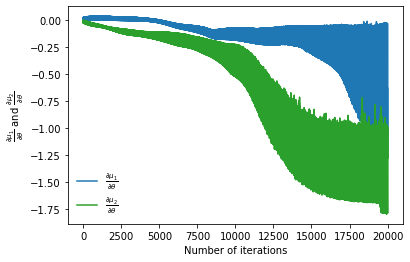

In [63]:
plt.plot(np.array(dμdθ_arr)[:, 0, 0], color="C0", label="$\\frac{\partial\mu_1}{\partial\\theta}$")
plt.plot(np.array(dμdθ_arr)[:, 0, 1], color="C2", label="$\\frac{\partial\mu_2}{\partial\\theta}$")
#plt.plot(np.array(test_dμdθ_arr)[:, 0, :], color="C1", label="$\left(\frac{\partial\mu}{\partial\theta}\right)_\textsf{test}$")
plt.xlabel("Number of iterations")
plt.ylabel("$\\frac{\partial\mu_1}{\partial\\theta}$ and $\\frac{\partial\mu_2}{\partial\\theta}$")
plt.legend(frameon=False);

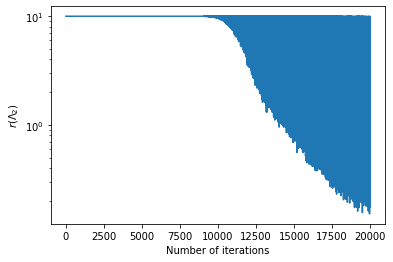

In [66]:
plt.plot(r_arr)
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("$r(\Lambda_2)$");